In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import time
from sklearn import preprocessing
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
air_reserve = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/air_reserve/air_reserve.csv")
hpg_reserve = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/hpg_reserve/hpg_reserve.csv")

air_store_info = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/air_store_info/air_store_info.csv")
store_station = pd.read_csv("C:/Users/divya/Downloads/rrv_weather_data/air_store_info_with_nearest_active_station.csv")
hpg_store_info = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/hpg_store_info/hpg_store_info.csv")

store_id_relation = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/store_id_relation/store_id_relation.csv")

air_visit_data = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/air_visit_data/air_visit_data.csv")
sub = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/sample_submission/sample_submission.csv")

date_info = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/date_info/date_info.csv")

In [3]:
test = sub.copy()
test['visit_date']=test['id'].str[-10:]
test['air_store_id']=test['id'].str[:-11]
test = test[['air_store_id','visit_date','visitors']]

In [4]:
all_data = pd.concat([air_visit_data,test])
all_data.shape

(284127, 3)

In [5]:
all_data['visitors'] = np.log1p(all_data['visitors'])
air_reserve['reserve_visitors'] = np.log1p(air_reserve['reserve_visitors'])

In [6]:
def transform(df):
    df['Day'] = (df['visit_date'].dt.day)
    df['Dayofweek'] = (df['visit_date'].dt.weekday)
    df['Month'] = (df['visit_date'].dt.month)
    df['Year'] = (df['visit_date'].dt.year)
    return df

In [7]:
all_data['visit_date']=pd.to_datetime(all_data['visit_date'])
all_data = transform(all_data)

In [8]:
# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.visit_date)

In [9]:
all_data.head(2)

,air_store_id,visit_date,visitors,Day,Dayofweek,Month,Year,Day_num
0,air_ba937bf13d40fb24,2016-01-13,3.258097,13,2,1,2016,12
1,air_ba937bf13d40fb24,2016-01-14,3.496508,14,3,1,2016,13


# Lag Features

In [10]:
def calculate_lag_dow(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['air_store_id','Dayofweek'])[column].shift(lag, fill_value=0)
    return df

In [11]:
df = all_data[['air_store_id','Dayofweek','visitors']].groupby(['air_store_id','Dayofweek']).agg({'visitors':'mean'}).reset_index()
df = df.rename(columns={'visitors':'visitors_mean_dow'}) 
all_data = all_data.merge(df,on=['air_store_id','Dayofweek'], how='left')

df = all_data[['air_store_id','Dayofweek','visitors']].groupby(['air_store_id','Dayofweek']).agg({'visitors':'sum'}).reset_index()
df = df.rename(columns={'visitors':'visitors_sum_dow'}) 
all_data = all_data.merge(df,on=['air_store_id','Dayofweek'], how='left')

del df
all_data.shape


(284127, 10)

In [12]:
all_data = calculate_lag_dow(all_data, [1], 'visitors_mean_dow')
all_data = calculate_lag_dow(all_data, [1], 'visitors_sum_dow')

In [13]:
def calculate_lag_mon(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['air_store_id','Month'])[column].shift(lag, fill_value=0)
    return df

In [14]:
df = all_data[all_data['Year']==2016][['air_store_id','Month','visitors']].groupby(['air_store_id','Month']).agg({'visitors':'mean'}).reset_index()
df = df.rename(columns={'visitors':'visitors_mean_mon'}) 
all_data = all_data.merge(df,on=['air_store_id','Month'], how='left')

del df
all_data.shape

(284127, 13)

In [15]:
all_data = calculate_lag_mon(all_data, [1], 'visitors_mean_mon')

In [16]:
all_data.set_index('visit_date',inplace=True)
expand_min = all_data.groupby(['air_store_id']).visitors_mean_dow.expanding().min().reset_index()
expand_min.rename(columns={'visitors_mean_dow':'expand_min'},inplace=True)

all_data.reset_index(inplace=True)
all_data = all_data.merge(expand_min, on=['air_store_id','visit_date'], how='left')
all_data.shape

del expand_min

In [17]:
all_data = calculate_lag_dow(all_data, [1], 'expand_min')

In [18]:
all_data.set_index('visit_date',inplace=True)
expand_max = all_data.groupby(['air_store_id']).visitors_mean_dow.expanding().max().reset_index()
expand_max.rename(columns={'visitors_mean_dow':'expand_max'},inplace=True)

all_data.reset_index(inplace=True)
all_data = all_data.merge(expand_max, on=['air_store_id','visit_date'], how='left')
all_data.shape

del expand_max

In [19]:
all_data = calculate_lag_dow(all_data, [1], 'expand_max')

In [20]:
all_data.set_index('visit_date',inplace=True)
expand_mean = all_data.groupby(['air_store_id']).visitors_mean_dow.expanding().mean().reset_index()
expand_mean.rename(columns={'visitors_mean_dow':'expand_mean'},inplace=True)

all_data.reset_index(inplace=True)
all_data = all_data.merge(expand_mean, on=['air_store_id','visit_date'], how='left')
all_data.shape

del expand_mean

In [21]:
all_data = calculate_lag_dow(all_data, [1], 'expand_mean')

# Air Reserve

In [22]:
air_reserve.head(2)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,0.693147
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,1.386294


In [23]:
#extract information from date
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date
air_reserve['reserve_date'] = pd.to_datetime(air_reserve['reserve_datetime']).dt.date
air_reserve['hour_diff']=(pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.seconds/3600
air_reserve['visit_date']=pd.to_datetime(air_reserve['visit_date'])

air_reserve = transform(air_reserve)
air_reserve.head(2)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,hour_diff,Day,Dayofweek,Month,Year
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,0.693147,2016-01-01,2016-01-01,3.0,1,4,1,2016
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,1.386294,2016-01-01,2016-01-01,0.0,1,4,1,2016


In [24]:
#aggregate the air reserve df on dates
air_final1 = air_reserve[['air_store_id','visit_date','reserve_visitors','hour_diff']].groupby(['air_store_id','visit_date']).agg({'reserve_visitors':'sum','hour_diff':'sum'}).reset_index()
#rename the columns
air_final1 = air_final1.rename(columns={'reserve_visitors':'air_rv_sum', 'hour_diff':'air_hour_diff_sum'})

#aggregate the air reserve df on dates
air_final2 = air_reserve[['air_store_id','visit_date','reserve_visitors','hour_diff']].groupby(['air_store_id','visit_date']).agg({'reserve_visitors':'mean','hour_diff':'mean'}).reset_index()
#rename the columns
air_final2 = air_final2.rename(columns={'reserve_visitors':'air_rv_mean', 'hour_diff':'air_hour_diff_mean'})

#merge both sum and mean df
air_final = air_final1.merge(air_final2, on = ['air_store_id','visit_date'], how='left')

#merge with air reserve
all_data = all_data.merge(air_final, on = ['air_store_id','visit_date'], how = 'left')
all_data.shape

del air_final1, air_final2, air_final

# Air Store Info

In [25]:
air_store_info.head(2)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


## latitude and longitude

In [26]:
air_loc = air_store_info[['air_store_id','latitude','longitude']]
air_loc.head(2)

,air_store_id,latitude,longitude
0,air_0f0cdeee6c9bf3d7,34.695124,135.197852
1,air_7cc17a324ae5c7dc,34.695124,135.197852


In [27]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

lat1 = air_store_info['latitude'].sum()/air_store_info['latitude'].count()
lng1 = air_store_info['longitude'].sum()/air_store_info['longitude'].count()
air_loc['haversine_dist'] = haversine_array(lat1, lng1, air_loc['latitude'], air_loc['longitude'])

C:\Users\divya\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [28]:
air_loc['longitude_15'] = air_loc['longitude']*np.cos(15* np.pi / 180) - air_loc['latitude']*np.sin(15* np.pi/180)
air_loc['longitude_30'] = air_loc['longitude']*np.cos(30* np.pi / 180) - air_loc['latitude']*np.sin(30* np.pi/180)
air_loc['longitude_45'] = air_loc['longitude']*np.cos(45* np.pi / 180) - air_loc['latitude']*np.sin(45* np.pi/180)
air_loc['longitude_60'] = air_loc['longitude']*np.cos(60* np.pi / 180) - air_loc['latitude']*np.sin(60* np.pi/180)
air_loc['longitude_75'] = air_loc['longitude']*np.cos(75* np.pi / 180) - air_loc['latitude']*np.sin(75* np.pi/180)

air_loc['latitude_15'] = air_loc['longitude']*np.sin(15* np.pi / 180) + air_loc['latitude']*np.cos(15* np.pi/180)
air_loc['latitude_30'] = air_loc['longitude']*np.sin(30* np.pi / 180) + air_loc['latitude']*np.cos(30* np.pi/180)
air_loc['latitude_45'] = air_loc['longitude']*np.sin(45* np.pi / 180) + air_loc['latitude']*np.cos(45* np.pi/180)
air_loc['latitude_60'] = air_loc['longitude']*np.sin(60* np.pi / 180) + air_loc['latitude']*np.cos(60* np.pi/180)
air_loc['latitude_75'] = air_loc['longitude']*np.sin(75* np.pi / 180) + air_loc['latitude']*np.cos(75* np.pi/180)

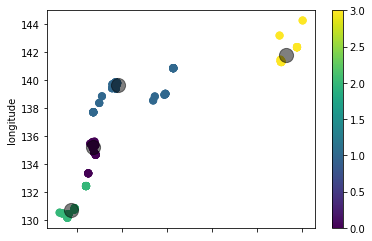

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(air_loc[air_loc.columns[1:3]]) # Compute k-means clustering.
air_loc['cluster_label'] = kmeans.fit_predict(air_loc[air_loc.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(air_loc[air_loc.columns[1:3]]) # Labels of each point

air_loc.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [30]:
del air_loc['latitude'], air_loc['longitude']
air_loc.head()

,air_store_id,haversine_dist,longitude_15,longitude_30,longitude_45,longitude_60,longitude_75,latitude_15,latitude_30,latitude_45,latitude_60,latitude_75,cluster_label
0,air_0f0cdeee6c9bf3d7,227.649705,121.611338,99.737213,71.066161,37.552067,1.478863,68.504696,97.645785,120.132476,134.432337,139.570856,0
1,air_7cc17a324ae5c7dc,227.649705,121.611338,99.737213,71.066161,37.552067,1.478863,68.504696,97.645785,120.132476,134.432337,139.570856,0
2,air_fee8dcf4d619598e,227.649705,121.611338,99.737213,71.066161,37.552067,1.478863,68.504696,97.645785,120.132476,134.432337,139.570856,0
3,air_a17f0778617c76e2,227.649705,121.611338,99.737213,71.066161,37.552067,1.478863,68.504696,97.645785,120.132476,134.432337,139.570856,0
4,air_83db5aff8f50478e,211.089887,125.760692,103.199401,73.605242,38.995007,1.727327,70.613424,100.756592,124.033365,138.857469,144.218666,1


In [31]:
all_data = all_data.merge(air_loc, on = 'air_store_id', how = 'left')
all_data.shape

(284127, 36)

In [32]:
del air_loc

# Stores per Genre

In [33]:
#merge with air genre
all_data = all_data.merge(air_store_info[['air_store_id','air_genre_name']].drop_duplicates(), on = ['air_store_id'], how = 'left')
all_data.shape

(284127, 37)

In [35]:
genre_count = air_store_info.groupby('air_genre_name').agg({'air_store_id':'count'}).reset_index()
genre_count = genre_count.rename(columns={'air_store_id':'store_count'})

all_data = all_data.merge(genre_count, on = ['air_genre_name'], how = 'left')
del genre_count

In [36]:
all_data.shape

(284127, 38)

# Checking missing data

In [37]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head(10)

,Total,Percent
air_rv_sum,254932,89.724665
air_hour_diff_sum,254932,89.724665
air_rv_mean,254932,89.724665
air_hour_diff_mean,254932,89.724665
visitors_mean_mon,68735,24.191647
visitors_mean_mon_1,66164,23.286770
store_count,0,0.000000
visitors_mean_dow_1,0,0.000000
expand_min,0,0.000000
visitors_sum_dow_1,0,0.000000


In [38]:
#all_data = all_data.groupby('air_store_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [39]:
all_data.fillna(0, inplace=True)

In [40]:
all_data.head(2)

,visit_date,air_store_id,visitors,Day,Dayofweek,Month,Year,Day_num,visitors_mean_dow,visitors_sum_dow,...,longitude_60,longitude_75,latitude_15,latitude_30,latitude_45,latitude_60,latitude_75,cluster_label,air_genre_name,store_count
0,2016-01-13,air_ba937bf13d40fb24,3.258097,13,2,1,2016,12,2.868858,200.820030,...,38.995007,1.727327,70.613424,100.756592,124.033365,138.857469,144.218666,1,Dining bar,108
1,2016-01-14,air_ba937bf13d40fb24,3.496508,14,3,1,2016,13,2.736528,191.556943,...,38.995007,1.727327,70.613424,100.756592,124.033365,138.857469,144.218666,1,Dining bar,108


# Convert Categorical Variables

In [41]:
all_data = pd.get_dummies(all_data, columns=['air_genre_name'])

In [78]:
#print("Encoded dataset")
# Label encode air store id. Save dictionary for exploration purposes
#all_data['air_store_id'] = le.fit_transform(all_data['air_store_id'])
#all_data['station_id'] = le.fit_transform(all_data['station_id'])

In [42]:
from sklearn.model_selection import KFold
def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 5
    n_inner_folds = 3
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean  
    
    
def frequency_encoding(df, col_name):
    new_name = "{}_counts".format(col_name)
    new_col_name = "{}_freq".format(col_name)
    grouped = df.groupby(col_name).size().reset_index(name=new_name)
    df = df.merge(grouped, how = "left", on = col_name)
    df[new_col_name] = df[new_name]/df[new_name].count()
    del df[new_name]
    return df

In [43]:
%%time
categorical_features = ["air_store_id"]

impact_coding_map = {}
for f in categorical_features:
        print("Impact coding for {}".format(f))
        all_data["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(all_data, f, target="visitors")
        impact_coding_map[f] = (impact_coding_mapping, default_coding)
        mapping, default_mean = impact_coding_map[f]
        
for cat in categorical_features:
    print("Frequency encoding for {}".format(f))
    all_data = frequency_encoding(all_data, cat)
        
    

Impact coding for air_store_id
Frequency encoding for air_store_id
Wall time: 2min 45s


In [44]:
train = all_data[all_data['Day_num']<478]
test = all_data[all_data['Day_num']>=478]

In [45]:
drop_cols=['visit_date','Day_num','visitors',
           'visitors_mean_dow','visitors_sum_dow','visitors_mean_mon',
          'air_rv_sum','air_hour_diff_sum','expand_min','expand_max','expand_mean','air_store_id']

In [46]:
X_train = train[train.Month.isin([1,2,3,4,5,6])].drop(drop_cols, axis=1)
Y_train = train[train.Month.isin([1,2,3,4,5,6])]['visitors']


X_valid = train[train.Month.isin([7,8,9,10,11,12])].drop(drop_cols, axis=1)
Y_valid = train[train.Month.isin([7,8,9,10,11,12])]['visitors']

X_test = test.drop(drop_cols, axis=1)
#X_test = X_test.drop(['date_block_num'],axis=1)

In [47]:
print('Train shape',X_train.shape)
print('Test shape',X_test.shape)

Train shape (125272, 41)
Test shape (32019, 41)


# Linear Regression

In [48]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
train_oof_lr = model_lr.predict(X_train)
valid_oof_lr = model_lr.predict(X_valid)
pred_lr = model_lr.predict(X_test)
sub['visitors']=np.expm1(pred_lr)
sub.to_csv('submission_lr.csv',index=False,float_format='%.4f') 

#with scaler - 2.91385
#without scaler - 0.57026

# Lasso Regression

In [50]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(random_state=42)

model_lasso.fit(X_train,Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [51]:
train_oof_ls = model_lasso.predict(X_train)
valid_oof_ls = model_lasso.predict(X_valid)
pred_ls = model_lasso.predict(X_test)
sub['visitors']=np.expm1(pred_ls)
sub.to_csv('submission_ls.csv',index=False,float_format='%.4f') 

#with scaler - 2.91385
#without scaler - 0.74222

# Light GBM

In [52]:
import lightgbm as lgb

params = {'num_leaves': 10,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'l2',
         "lambda_l1": 0.2,
         "verbosity": -1,
         "random_state":42
         }

model_lgb = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1,seed=40)
model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], eval_metric='rmse',verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.248003	training's rmse: 0.497999	valid_1's l2: 0.266054	valid_1's rmse: 0.515804
[2000]	training's l2: 0.238182	training's rmse: 0.488039	valid_1's l2: 0.261575	valid_1's rmse: 0.511445
[3000]	training's l2: 0.232474	training's rmse: 0.482156	valid_1's l2: 0.259758	valid_1's rmse: 0.509665
Early stopping, best iteration is:
[3531]	training's l2: 0.230158	training's rmse: 0.479748	valid_1's l2: 0.259198	valid_1's rmse: 0.509115


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='l2', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=10,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, seed=40, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, ...)

In [53]:
train_oof_lgb = model_lgb.predict(X_train, num_iteration=model_lgb.best_iteration_)
valid_oof_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration_)
sub['visitors']=np.expm1(pred_lgb)
sub.to_csv('submission_lgb.csv',index=False,float_format='%.4f') #0.49693

# XGBoost

In [54]:
from xgboost.sklearn import XGBClassifier, XGBRegressor

xgb_params = {'max_depth' : 11,            
              'min_child_weight' : 0.5, 
            'colsample_bytree' : 0.8, 
            'subsample':1, 
            'learning_rate':0.01,
            'eta':0.01,    
            'seed':40,
            'random_state':42
             }

model_xgb = XGBRegressor(**xgb_params, n_estimators = 20000)
model_xgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
              eval_metric='rmse',verbose=1000, early_stopping_rounds=10)

[0]	validation_0-rmse:2.42799	validation_1-rmse:2.40608
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[571]	validation_0-rmse:0.408805	validation_1-rmse:0.519057



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, eta=0.01, gamma=0, learning_rate=0.01,
             max_delta_step=0, max_depth=11, min_child_weight=0.5, missing=None,
             n_estimators=20000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=40, silent=True, subsample=1)

In [55]:
train_oof_xgb = model_xgb.predict(X_train)
valid_oof_xgb = model_xgb.predict(X_valid)
pred_xgb = model_xgb.predict(X_test)
sub['visitors']=np.expm1(pred_xgb)
sub.to_csv('submission_xgb.csv',index=False,float_format='%.4f') #0.48279

# Stacking LGB and XGB using LGB

In [56]:
train_stack1 = np.vstack([train_oof_lgb, train_oof_xgb]).transpose()
train_stack1 = pd.DataFrame(train_stack1, columns=['lgb', 'xgb'])
valid_stack1 = np.vstack([valid_oof_lgb, valid_oof_xgb]).transpose()
valid_stack1 = pd.DataFrame(valid_stack1, columns=['lgb', 'xgb'])
test_stack1 = np.vstack([pred_lgb, pred_xgb]).transpose()
test_stack1 = pd.DataFrame(test_stack1, columns=['lgb', 'xgb'])

In [57]:
import lightgbm as lgb

params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'l2',
         "lambda_l1": 0.2,
         "verbosity": -1,
         "random_state":42,
          "seed":40
         }

model_lgb_stack1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model_lgb_stack1.fit(train_stack1, Y_train, eval_set=[(train_stack1, Y_train), (valid_stack1, Y_valid)], 
                 eval_metric='rmse',verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's l2: 0.175669	training's rmse: 0.419129	valid_1's l2: 0.270538	valid_1's rmse: 0.520133


LGBMRegressor(bagging_seed=11, boosting='gbdt', boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              lambda_l1=0.2, learning_rate=0.01, max_depth=2, metric='l2',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
              min_split_gain=0.0, n_estimators=20000, n_jobs=-1, nthread=4,
              num_leaves=8, objective='regression', random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, seed=40, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbosity=-1)

In [58]:
pred_lgb_stack1 = model_lgb_stack1.predict(test_stack1, num_iteration=model_lgb_stack1.best_iteration_) 
sub['visitors']=np.expm1(pred_lgb_stack1) 
sub.to_csv('submission_lgb_stack1.csv',index=False,float_format='%.4f') #0.49180

# Stacking LGB and XGB using XGB

In [59]:
from xgboost.sklearn import XGBClassifier, XGBRegressor

xgb_params = {'max_depth' : 5,            
              'min_child_weight' : 0.5, 
            'colsample_bytree' : 0.8, 
            'subsample':1, 
            'eta':0.01,    
            'seed':42,
             'random':40
             }

model_xgb_stack1 = XGBRegressor(**xgb_params, n_estimators = 20000)
model_xgb_stack1.fit(train_stack1, Y_train, eval_set=[(train_stack1, Y_train), (valid_stack1, Y_valid)], eval_metric='rmse',verbose=1000, early_stopping_rounds=10)

[0]	validation_0-rmse:2.21343	validation_1-rmse:2.19932
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[49]	validation_0-rmse:0.421327	validation_1-rmse:0.517315



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, eta=0.01, gamma=0, learning_rate=0.1,
             max_delta_step=0, max_depth=5, min_child_weight=0.5, missing=None,
             n_estimators=20000, n_jobs=1, nthread=None, objective='reg:linear',
             random=40, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [60]:
pred_xgb_stack1 = model_xgb_stack1.predict(test_stack1)
sub['visitors']=np.expm1(pred_xgb_stack1)
sub.to_csv('submission_xgb_stack1.csv',index=False,float_format='%.4f') #0.48745

# Blending with LGB and XGB

In [61]:
sub['visitors'] = np.expm1((pred_lgb + pred_xgb) / 2)
sub.to_csv("blend_lgb_xgb.csv", index=False) #0.48800

In [62]:
sub['visitors'] = np.expm1((pred_lgb_stack1 + pred_xgb_stack1) / 2)
sub.to_csv("blend_lgb_xgb_stack.csv", index=False) #0.48395

In [63]:
sub['visitors'] = np.expm1((0.4*pred_lgb + 0.6*pred_xgb))
sub.to_csv("blend_lgb_xgb_wt.csv", index=False) #0.48704

# Gradient Boost

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'max_depth': 5,
         'n_estimators':2000,
          'learning_rate':0.1,
          'subsample':0.8,
         "random_state":42,
          "seed":40
         }
model_gbr = GradientBoostingRegressor()

model_gbr.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
train_oof_gbr = model_gbr.predict(X_train)
valid_oof_gbr = model_gbr.predict(X_valid)
pred_gbr = model_gbr.predict(X_test)
sub['visitors']=np.expm1(pred_gbr)
sub.to_csv('submission_gbr.csv',index=False,float_format='%.4f') #0.51489

# Stacking LGB, XGB, GBR using LGB

In [66]:
train_stack2 = np.vstack([train_oof_lgb, train_oof_xgb, train_oof_gbr]).transpose()
train_stack2 = pd.DataFrame(train_stack2, columns=['lgb', 'xgb', 'gbr'])
valid_stack2 = np.vstack([valid_oof_lgb, valid_oof_xgb, valid_oof_gbr]).transpose()
valid_stack2 = pd.DataFrame(valid_stack2, columns=['lgb', 'xgb', 'gbr'])
test_stack2 = np.vstack([pred_lgb, pred_xgb, pred_gbr]).transpose()
test_stack2 = pd.DataFrame(test_stack2, columns=['lgb', 'xgb', 'gbr'])

In [67]:
import lightgbm as lgb

params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'l2',
         "lambda_l1": 0.2,
         "verbosity": -1,
         "random_state":42,
          "seed":40
         }

model_lgb_stack2 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model_lgb_stack2.fit(train_stack2, Y_train, eval_set=[(train_stack2, Y_train), (valid_stack2, Y_valid)], 
                 eval_metric='rmse',verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's l2: 0.175669	training's rmse: 0.419129	valid_1's l2: 0.270538	valid_1's rmse: 0.520133


LGBMRegressor(bagging_seed=11, boosting='gbdt', boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              lambda_l1=0.2, learning_rate=0.01, max_depth=2, metric='l2',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
              min_split_gain=0.0, n_estimators=20000, n_jobs=-1, nthread=4,
              num_leaves=8, objective='regression', random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, seed=40, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbosity=-1)

In [68]:
pred_lgb_stack2 = model_lgb_stack2.predict(test_stack2, num_iteration=model_lgb_stack2.best_iteration_)
sub['visitors']=np.expm1(pred_lgb_stack2)
sub.to_csv('submission_lgb_stack2.csv',index=False,float_format='%.4f') #0.49180

# Stacking LGB, XGB, GBR using XGB

In [69]:
from xgboost.sklearn import XGBClassifier, XGBRegressor

xgb_params = {'max_depth' : 5,            
              'min_child_weight' : 0.5, 
            'colsample_bytree' : 0.8, 
            'subsample':1, 
            'eta':0.01,    
            'seed':42,
             'random':40
             }

model_xgb_stack2 = XGBRegressor(**xgb_params, n_estimators = 20000)
model_xgb_stack2.fit(train_stack2, Y_train, eval_set=[(train_stack2, Y_train), (valid_stack2, Y_valid)], 
                     eval_metric='rmse',verbose=1000, early_stopping_rounds=10)

[0]	validation_0-rmse:2.21294	validation_1-rmse:2.20117
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[34]	validation_0-rmse:0.387099	validation_1-rmse:0.541049



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, eta=0.01, gamma=0, learning_rate=0.1,
             max_delta_step=0, max_depth=5, min_child_weight=0.5, missing=None,
             n_estimators=20000, n_jobs=1, nthread=None, objective='reg:linear',
             random=40, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [70]:
pred_xgb_stack2 = model_xgb_stack2.predict(test_stack2)
sub['visitors']=np.expm1(pred_xgb_stack2)
sub.to_csv('submission_xgb_stack2.csv',index=False,float_format='%.4f') #0.49765

# KNeighbors

In [71]:
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=15)
model_knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
                    weights='uniform')

In [72]:
train_oof_knn = model_knn.predict(X_train)
valid_oof_knn = model_knn.predict(X_valid)
pred_knn = model_knn.predict(X_test)
sub['visitors']=np.expm1(pred_knn)
sub.to_csv('submission_knn.csv',index=False,float_format='%.4f') #0.52786

# Blending with LGB, XGB, Gradient

In [73]:
sub['visitors'] = np.expm1((pred_lgb + pred_xgb + pred_gbr) / 3)
sub.to_csv("blend_lgb_xgb_gbr.csv", index=False) #0.49387

# Blending with LGB, XGB, Gradient and KNN

In [74]:
sub['visitors'] = np.expm1((pred_lgb + pred_xgb + pred_gbr + pred_knn) / 4)
sub.to_csv("blend_lgb_xgb_gbr_knn.csv", index=False) #0.49447

# Blending with LGB, XGB, Gradient and KNN with weights

In [75]:
sub['visitors'] = np.expm1((0.2*pred_lgb + 0.6*pred_xgb + 0.1*pred_gbr +0.1*pred_knn))
sub.to_csv("blend_lgb_xgb_gbr_wt.csv", index=False) #0.48737

# Gmean

In [76]:
#concatenate target columns on the same Dataframe
sub = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/sample_submission/sample_submission.csv")
sub1 = sub.copy()
sub1['visitors']=np.expm1(pred_lgb)

sub2 = sub.copy()
sub2['visitors']=np.expm1(pred_xgb)

#sub3 = sub.copy()
#sub3['visitors']=np.expm1(pred_gbr)

#sub4 = sub.copy()
#sub4['visitors']=np.expm1(pred_knn)

preds = pd.concat([sub1['visitors'], sub2['visitors']])#,  sub3['visitors'], sub4['visitors']])

from scipy.stats.mstats import gmean

#Apply geometric mean 
preds = preds.groupby(level=0).apply(gmean)

sub['visitors'] = preds
sub.to_csv("blend_gmean.csv", index=False) #0.48801

In [77]:
#concatenate target columns on the same Dataframe
sub = pd.read_csv("C:/Users/divya/Downloads/recruit-restaurant-visitor-forecasting/sample_submission/sample_submission.csv")
sub1 = sub.copy()
sub1['visitors']=np.expm1(pred_lgb_stack1)

sub2 = sub.copy()
sub2['visitors']=np.expm1(pred_xgb_stack1)

#sub3 = sub.copy()
#sub3['visitors']=np.expm1(pred_gbr)

#sub4 = sub.copy()
#sub4['visitors']=np.expm1(pred_knn)

preds = pd.concat([sub1['visitors'], sub2['visitors']])#,  sub3['visitors'], sub4['visitors']])

from scipy.stats.mstats import gmean

#Apply geometric mean 
preds = preds.groupby(level=0).apply(gmean)

sub['visitors'] = preds
sub.to_csv("blend_gmean_stack.csv", index=False) #0.48801